In [41]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import yfinance as yf
import torch.nn as nn
import torch.autograd as tgrad
from european_utils import EuropeanOptionData, plot_solution
from scipy import special
%matplotlib inline

In [42]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
class PINNs(nn.Module):
  def __init__(self, in_dim, out_dim, hidden_dim, num_layer):
    super(PINNs, self).__init__()

    layers = []
    for i in range(num_layer - 1):
      if i == 0:
        layers.append(nn.Linear(in_features=in_dim, out_features=hidden_dim))
        layers.append(nn.Tanh())
      else:
        layers.append(nn.Linear(in_features=hidden_dim, out_features=hidden_dim))
        layers.append(nn.Tanh())

    layers.append(nn.Linear(in_features=hidden_dim, out_features=out_dim))

    self.linear = nn.Sequential(*layers)

  def forward(self, x):
    # src = torch.cat((x, t), dim=-1)
    return self.linear(x)

In [44]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

In [45]:
N_EPOCH = 120000
LEARNING_RATE = 1e-5
HIDDEN_LAYER = 5
HIDDEN_WIDTH = 256
N_sample = 2000
EXPERIMENT_NAME = "exp_euro_call_market"
PHYSICS_PENALTY = 12
MODEL_TYPE = PINNs
BVP1_PENALTY = 3
ERR_SAMPLING = False

experiment_dir = f"./{EXPERIMENT_NAME}"
os.makedirs(experiment_dir, exist_ok=True)

In [46]:
import logging
from datetime import datetime
logger = logging.getLogger()
current_date = datetime.now().strftime("%Y-%m-%d")
log_file_name = f"{experiment_dir}/{EXPERIMENT_NAME}_log_{current_date}.log"
fhandler = logging.FileHandler(filename=log_file_name, mode='w')
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fhandler.setFormatter(formatter)
logger.addHandler(fhandler)
logger.setLevel(logging.INFO)

In [47]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.set_default_device(DEVICE)
logging.info(f"Running on device={DEVICE}")

In [48]:
logging.info(f"N_EPOCH: {N_EPOCH}")
logging.info(f"LEARNING_RATE: {LEARNING_RATE}")
logging.info(f"HIDDEN_LAYER: {HIDDEN_LAYER}")
logging.info(f"HIDDEN_WIDTH: {HIDDEN_WIDTH}")
logging.info(f"N_sample: {N_sample}")
logging.info(f"EXPERIMENT_NAME: {EXPERIMENT_NAME}")
logging.info(f"PHYSICS_PENALTY: {PHYSICS_PENALTY}")
logging.info(f"BVP1_PENALTY: {BVP1_PENALTY}")
logging.info(f"ERR_SAMPLING: {ERR_SAMPLING}")
logging.info(f"Model type: {MODEL_TYPE.__name__}")

In [11]:
call_data = pd.read_csv("./NDX_call_data.csv")
call_data.head()

,Unnamed: 0,spot_price,current_time,strike_price,best_bid,best_offer,ticker,impl_volatility,market_price
0,0,14137.230469,0.989041,15700.0,493.5,528.5,NDX,0.196978,511.00
1,1,14270.419922,0.986301,15700.0,530.6,557.9,NDX,0.195356,544.25
2,2,14274.240234,0.983562,15700.0,515.7,544.3,NDX,0.192452,530.00
3,3,14365.959961,0.980822,15700.0,552.5,592.4,NDX,0.194887,572.45
4,4,14345.179688,0.978082,15700.0,539.3,575.6,NDX,0.193641,557.45


In [16]:
# For risk free rate
treasury_yield_data = yf.download("^IRX", start='2021-06-14', end='2022-06-28')
treasury_yield_data.mean()

[*********************100%%**********************]  1 of 1 completed


Open         0.317221
High         0.325519
Low          0.306634
Close        0.317248
Adj Close    0.317248
Volume       0.000000
dtype: float64

In [49]:
K = 15700.0
r = 0.32
sigma = 0.25
T = 1
S_range = [call_data["spot_price"].min(), call_data["spot_price"].max()]
t_range = [0, T]

In [50]:
euro_call_data = EuropeanOptionData(t_range,S_range,K,r,sigma)

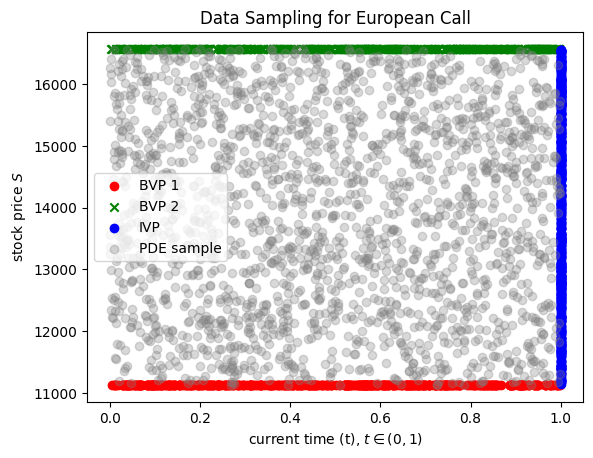

In [51]:
bvp_x1,bvp_y1,bvp_x2,bvp_y2 = euro_call_data.get_bvp_data(500,1,1)
ivp_x1,ivp_y1 = euro_call_data.get_ivp_data(500,1)
diff_x1,diff_y1 = euro_call_data.get_diff_data(2000)
plt.scatter(bvp_x1[:,0],bvp_x1[:,1], label= "BVP 1", color = "red",marker="o")
plt.scatter(bvp_x2[:,0],bvp_x2[:,1], label= "BVP 2", color = "green",marker="x")
plt.scatter(ivp_x1[:,0],ivp_x1[:,1], label= "IVP", color = "blue")
plt.scatter(diff_x1[:,0],diff_x1[:,1], label= "PDE sample", color = "grey", alpha = 0.3)
plt.xlabel(f"current time (t), $t \in (0,1)$")
plt.ylabel("stock price $S$")
plt.title("Data Sampling for European Call")
plt.legend()

In [52]:
model = MODEL_TYPE(2,1,HIDDEN_WIDTH, HIDDEN_LAYER + 1).to(DEVICE)
model.apply(init_weights)
logging.info(f"Model parameters : {sum(p.numel() for p in model.parameters())/10**3:.2f}K")

In [53]:
# N_sample = 500
physics_lr = PHYSICS_PENALTY
optimizer = torch.optim.Adam(model.parameters(),lr=LEARNING_RATE)

loss_history={
    "total_loss":[],"loss_ivp_bvp":[],"loss_BS":[],\
    "loss_bvp1":[],"loss_bvp2":[],"loss_ivp":[],
}

In [54]:
def get_sample_rt(l1,l2,l3):
    t = l1+l2+l3
    l1 = max(l1*3/t,0.25)
    l2 = max(l2*3/t,0.25)
    l3 = max(l3*3/t,0.25)
    return (l1,l2,l3)

In [55]:
r_ivp,r_bvp1,r_bvp2 = 1,1,1
for i in range(N_EPOCH):
    model.train();
    # Get IVP data
    ivp_x_tensor,ivp_y_tensor = euro_call_data.get_ivp_data_tensor(N_sample,r_ivp)
    ivp_x_tensor = ivp_x_tensor.to(DEVICE)
    ivp_y_tensor = ivp_y_tensor.to(DEVICE)
    # ivp_x_tensor = euro_call_data.normalize(ivp_x_tensor)
    ivp_y_pred = model(ivp_x_tensor)
    mse_ivp = nn.MSELoss()(ivp_y_tensor, ivp_y_pred)

    # Get BVP data
    bvp_x1_tensor,bvp_y1_tensor,bvp_x2_tensor,bvp_y2_tensor = euro_call_data.get_bvp_data_tensor(N_sample,r_bvp1,r_bvp2)
    bvp_x1_tensor,bvp_y1_tensor = bvp_x1_tensor.to(DEVICE),bvp_y1_tensor.to(DEVICE)
    bvp_x2_tensor,bvp_y2_tensor = bvp_x2_tensor.to(DEVICE),bvp_y2_tensor.to(DEVICE)
    # bvp_x1_tensor = euro_call_data.normalize(bvp_x1_tensor)
    bvp_y1_pred = model(bvp_x1_tensor)
    mse_bvp1 = nn.MSELoss()(bvp_y1_tensor, bvp_y1_pred)
    # bvp_x2_tensor = euro_call_data.normalize(bvp_x2_tensor)
    bvp_y2_pred = model(bvp_x2_tensor)
    mse_bvp2 = nn.MSELoss()(bvp_y2_tensor, bvp_y2_pred)

    # Aggregate the "data loss"
    loss1 = mse_ivp + BVP1_PENALTY*mse_bvp1 + mse_bvp2

    # Compute the "Black-Scholes loss"
    X1,y1 = euro_call_data.get_diff_data(N_sample)
    X1 = torch.from_numpy(X1).float().requires_grad_().to(DEVICE)
    y1 = torch.from_numpy(y1).float().to(DEVICE)
    y1_hat = model(X1)
    grads = torch.autograd.grad(y1_hat, X1, grad_outputs=torch.ones(y1_hat.shape).to(DEVICE), retain_graph=True, create_graph=True, only_inputs=True)[0]
    dVdt, dVdS = grads[:, 0].view(-1, 1), grads[:, 1].view(-1, 1)
    grads2nd = torch.autograd.grad(dVdS, X1, grad_outputs=torch.ones(dVdS.shape).to(DEVICE), create_graph=True, only_inputs=True)[0]
    d2VdS2 = grads2nd[:, 1].view(-1, 1)
    S1 = X1[:, 1].view(-1, 1)
    bs_pde = dVdt + (0.5 * ((sigma * S1) ** 2) * d2VdS2) + (r * S1 * dVdS)
    loss2 = physics_lr * nn.MSELoss()(bs_pde, torch.zeros_like(r * y1_hat))

    # Backpropagate joint loss
    loss = loss1 + loss2
    loss_history["total_loss"].append(loss.item())
    loss_history["loss_ivp_bvp"].append(loss1.item())
    loss_history["loss_BS"].append(loss2.item())
    loss_history["loss_ivp"].append(mse_ivp.item())
    loss_history["loss_bvp1"].append(mse_bvp1.item())
    loss_history["loss_bvp2"].append(mse_bvp2.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    #normalise the ratios
    if ERR_SAMPLING:
      r_ivp,r_bvp1,r_bvp2 = get_sample_rt(mse_ivp.item(),mse_bvp1.item(),mse_bvp2.item())
    # Plot the result as training progresses
    if (i + 1) % 500 == 0:
        logging.info(f"Epoch {i+1}, Loss: {loss.item():.4f}")
        if DEVICE.type !="cuda":
          print(f"Epoch {i+1}, Loss: {loss.item():.4f}")
    if (i+1) % 10000 == 0:
      plot_solution(model, euro_call_data, i+1, experiment_dir)

KeyboardInterrupt: 

### Working with market data

In [7]:
# For risk free rate
treasury_yield_data = yf.download("^IRX", start='2021-06-14', end='2022-06-28')
treasury_yield_data.mean()

[*********************100%%**********************]  1 of 1 completed


Open         0.317221
High         0.325519
Low          0.306634
Close        0.317248
Adj Close    0.317248
Volume       0.000000
dtype: float64

In [8]:
call_data.head()

,Unnamed: 0,spot_price,current_time,strike_price,best_bid,best_offer,ticker,impl_volatility,market_price
0,0,14137.230469,0.989041,15700.0,493.5,528.5,NDX,0.196978,511.00
1,1,14270.419922,0.986301,15700.0,530.6,557.9,NDX,0.195356,544.25
2,2,14274.240234,0.983562,15700.0,515.7,544.3,NDX,0.192452,530.00
3,3,14365.959961,0.980822,15700.0,552.5,592.4,NDX,0.194887,572.45
4,4,14345.179688,0.978082,15700.0,539.3,575.6,NDX,0.193641,557.45


In [9]:
market_spot_price =  call_data["spot_price"].to_numpy()
market_current_time =  call_data["current_time"].to_numpy()
market_spot_price.shape, market_current_time.shape

((239,), (239,))

In [10]:
X_test = torch.tensor(np.column_stack((market_current_time, market_spot_price)), dtype=torch.float)
# X_test = np.column_stack((s_flat, t_flat))
X_test.shape

torch.Size([239, 2])

In [11]:
y_true = call_data["market_price"].to_numpy()
y_true.shape

(239,)

In [12]:
model.eval();
with torch.no_grad():
  y_pinn_test = model(X_test)

y_pinn_test.shape

torch.Size([239, 1])

In [13]:
err = (y_pinn_test-y_true)
loss_mse = np.square(err).sum()/(len(err))
print(f"MSE net: {loss_mse:.3f}")
# logging.info(f"MSE net: {loss_mse:.3f}")

MSE net: 127090225.117


In [18]:
model(torch.tensor([0.989041, 11127.230469]))

tensor([124.0562], grad_fn=<ViewBackward0>)

In [23]:
# S_range = [market_spot_price.min(), market_spot_price.max()]
# t_range = [market_current_time.min(), market_current_time.max()]
S_range = [0, 160]
t_range = [0, 1]
s = np.linspace(S_range[0], S_range[1], 100)
t = np.linspace(t_range[0], t_range[1], 100)
s_grid, t_grid = np.meshgrid(s, t)
s_flat = s_grid.flatten()
t_flat = t_grid.flatten()
# Create a 2D tensor from the flattened arrays
X_test = torch.tensor(np.column_stack((t_flat, s_flat)), dtype=torch.float)
# X_test_norm = euro_call_data.normalize(X_test)
# y_analytical_test = euro_call_data.get_analytical_soln(X_test[:,1],X_test[:,0])
model.eval();
with torch.no_grad():
  y_pinn_test = model(X_test)